### Project Setup

In [2355]:
!pip install seaborn
!pip install scipy
!pip install scikit-learn

import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


### Citirea setului de date

In [2356]:
# Citirea setului de date
df = pd.read_csv('dataset.csv')

### Filtrarea datelor

In [2357]:
# Eliminam din dataset NaN si +- Inifity
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

In [2358]:
# Inlocuiesc NaN si +- Infinity cu mediana pe coloane pentru
#df = df.replace([np.inf, -np.inf], np.nan)
#df = df.apply(lambda x: x.fillna(x.median()), axis=0)

# 3.1. Explorarea Datelor (Exploratory Data Analysis)

## 1. Analiza Echilibrului de Clase

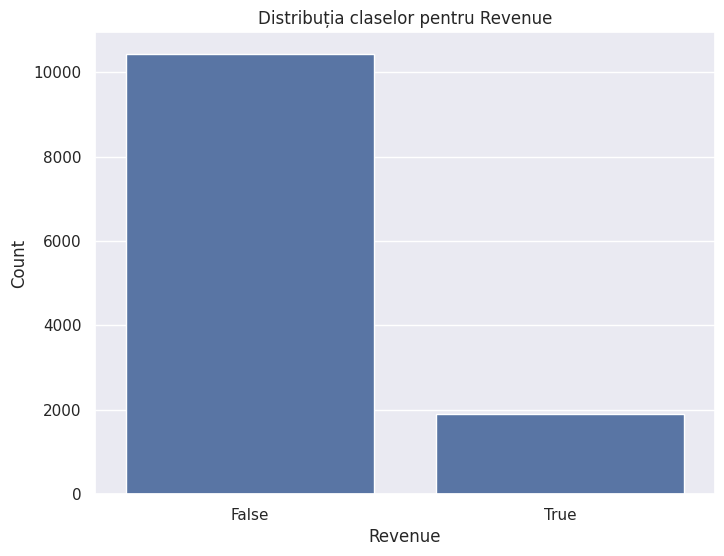

In [2377]:
# Verificarea echilibrului claselor
plt.figure(figsize=(8, 6))
sns.countplot(x='Revenue', data=df)
plt.title('Distribuția claselor pentru Revenue')
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.show()

## 2. Vizualizarea Atributelor

### 2.A Atribute Numerice

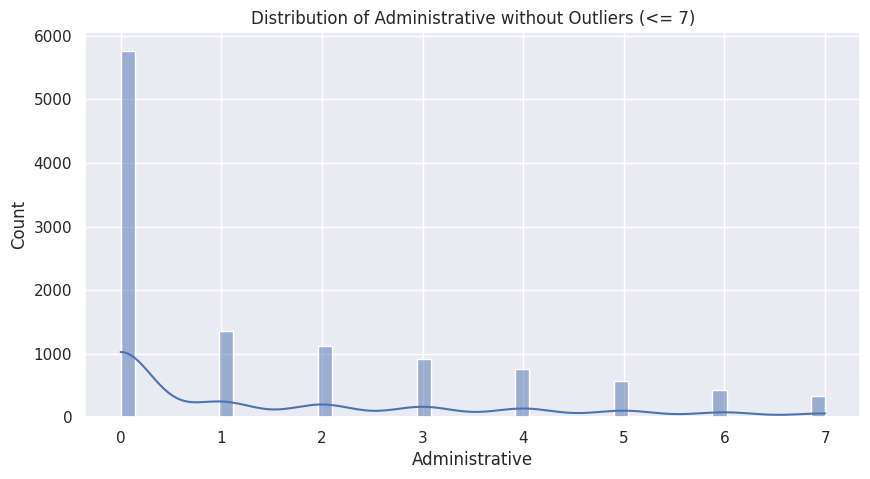

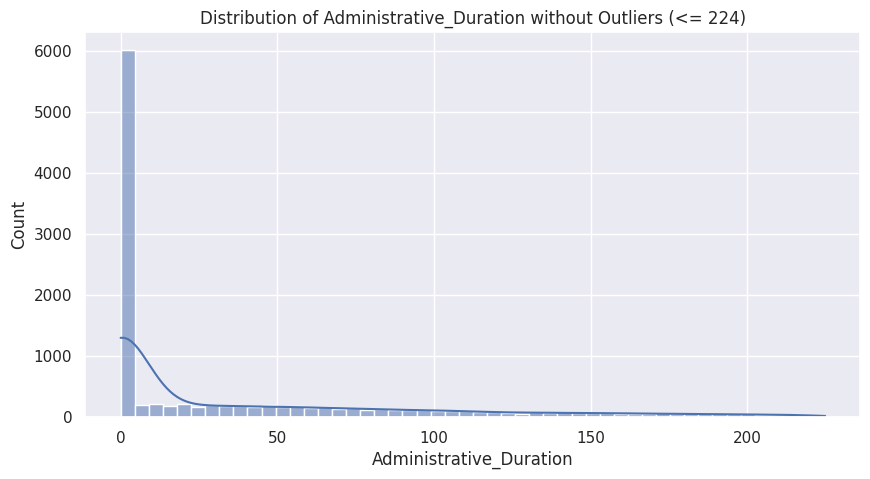

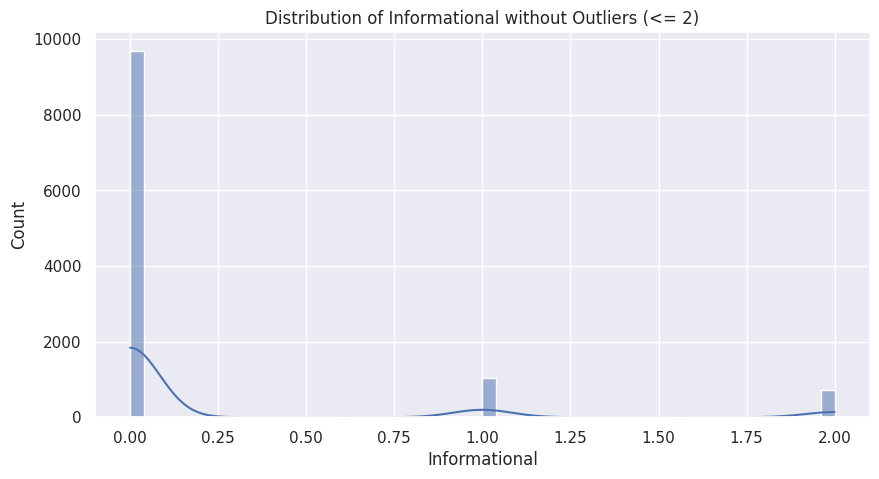

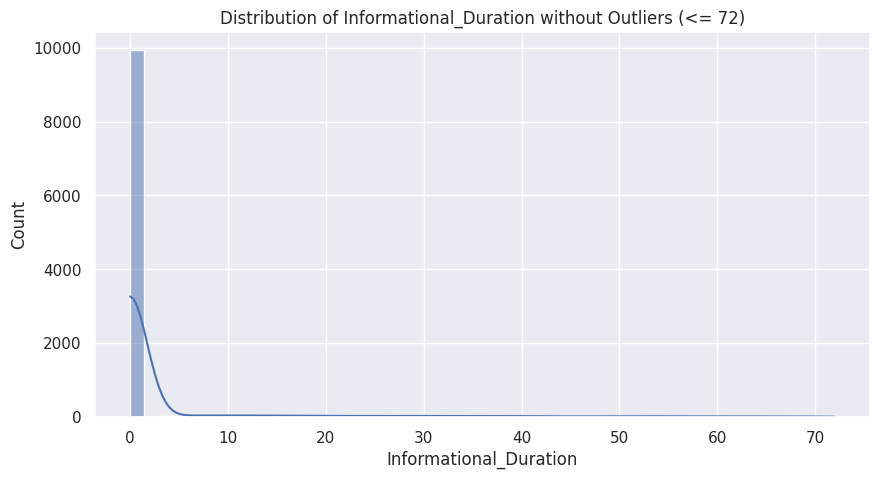

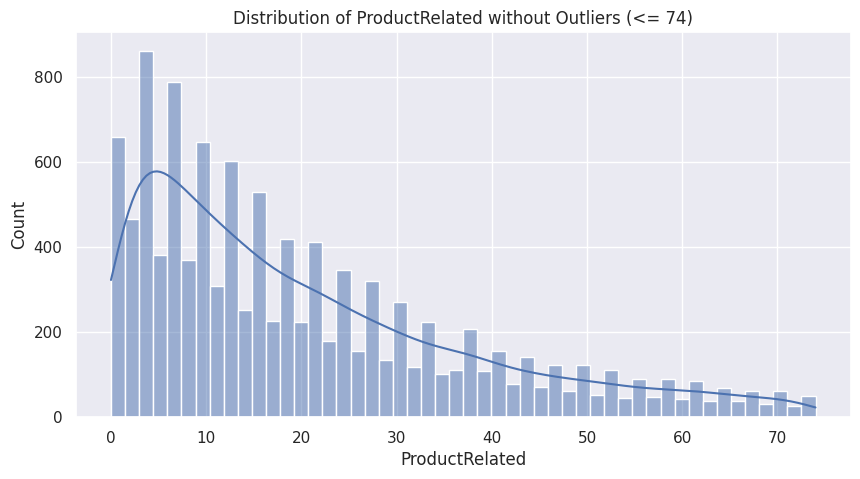

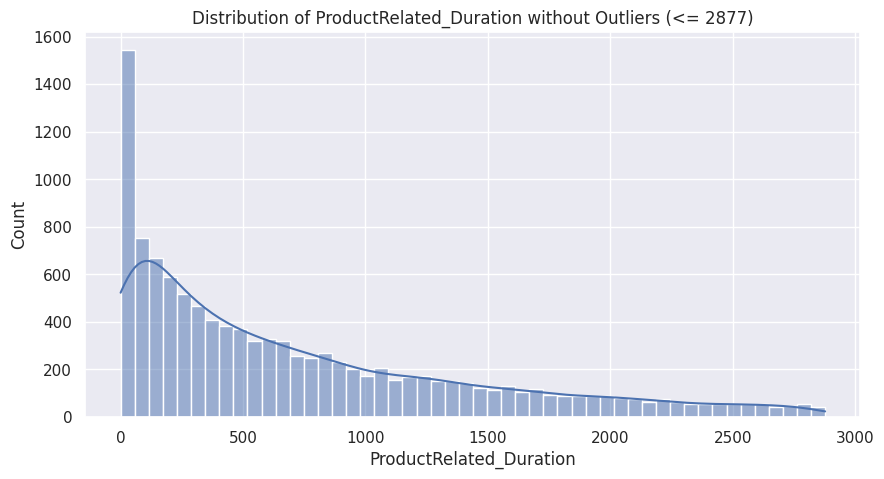

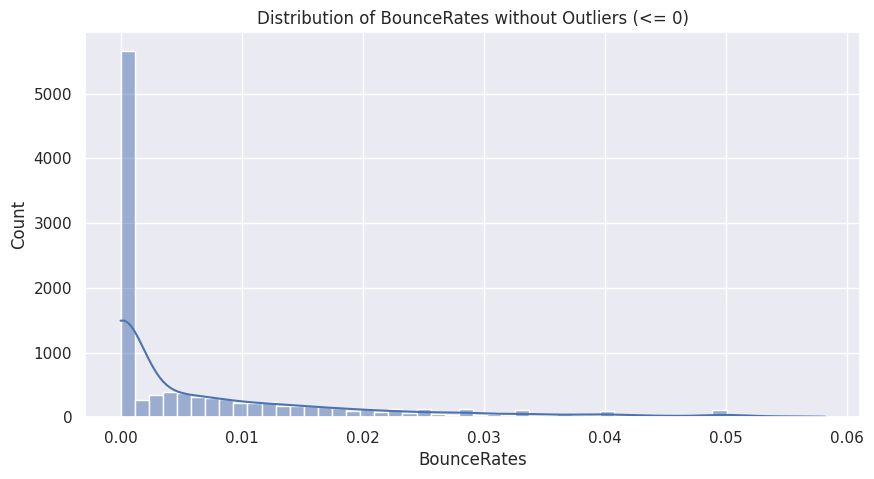

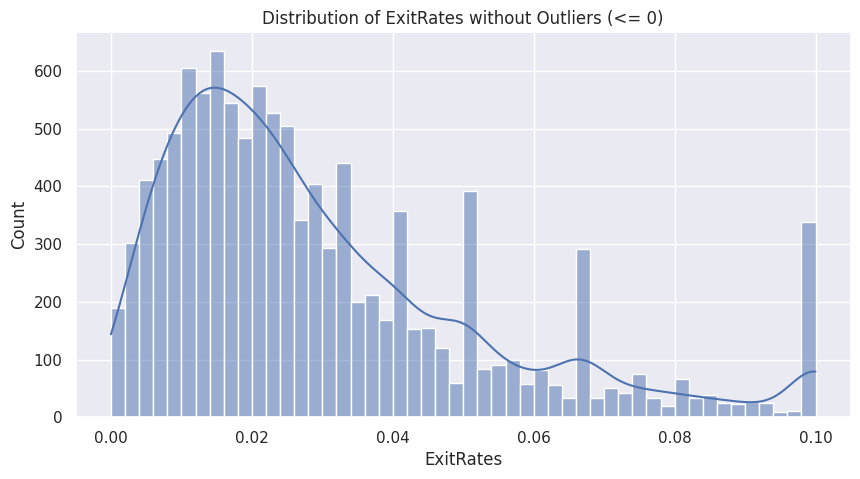

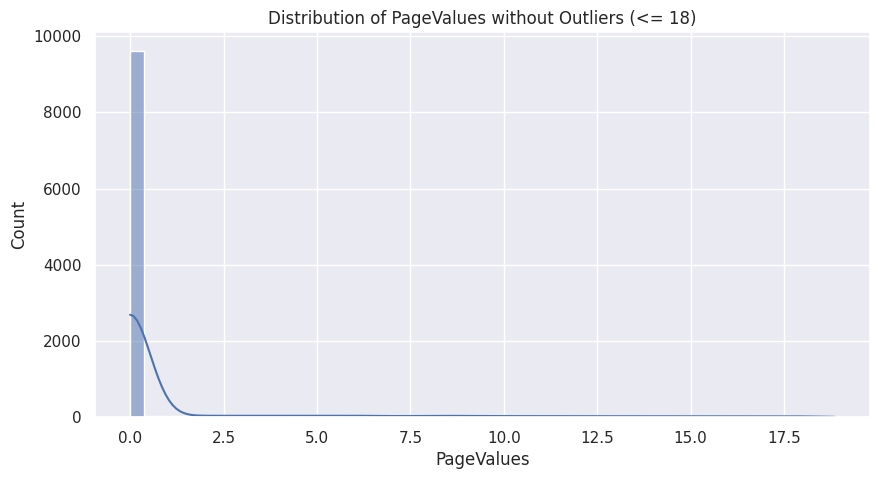

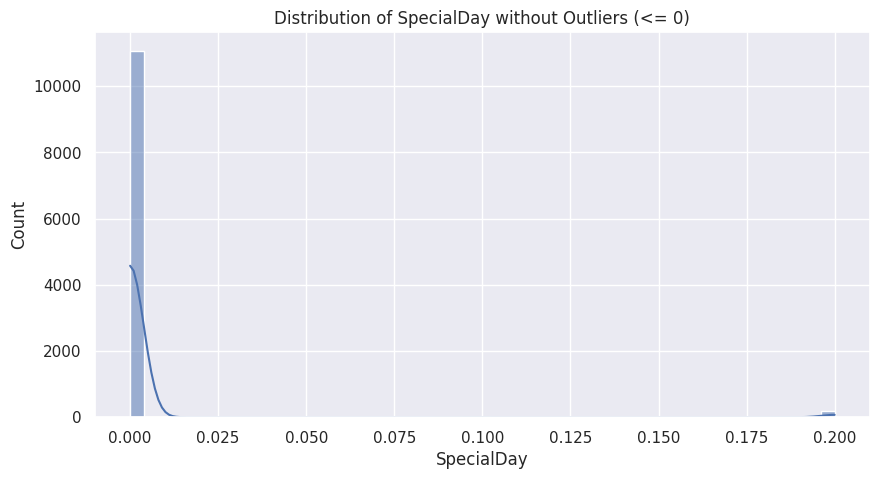

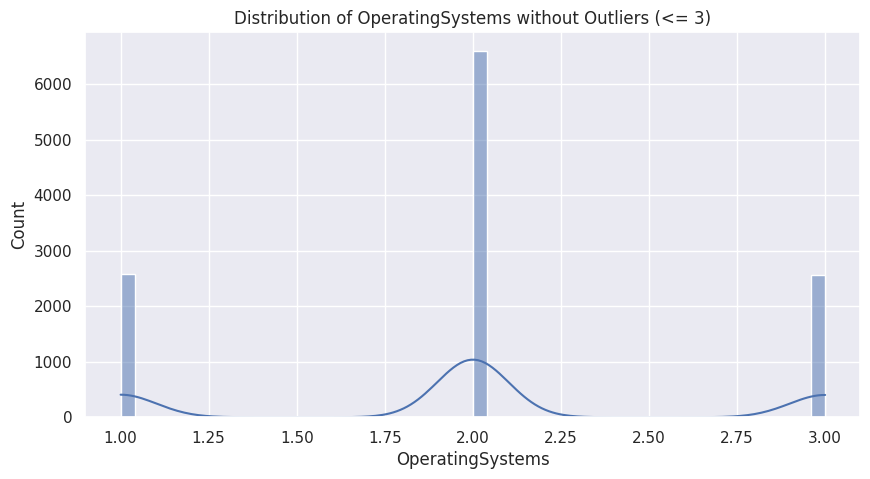

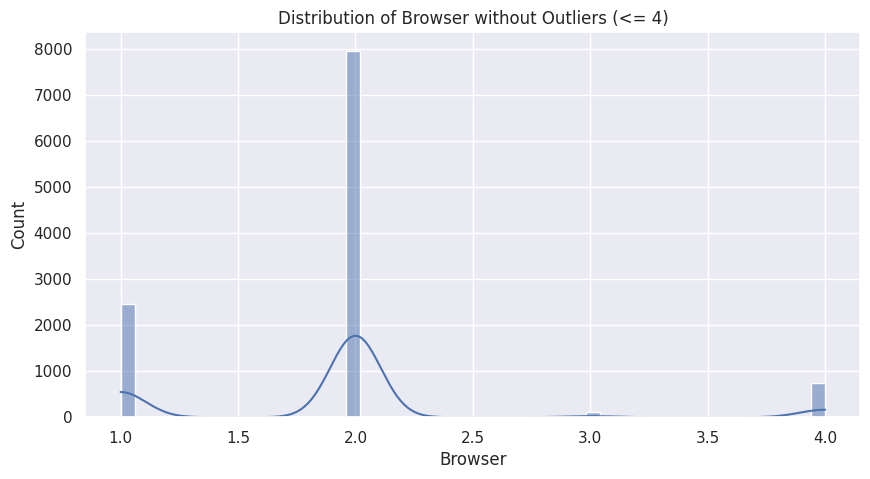

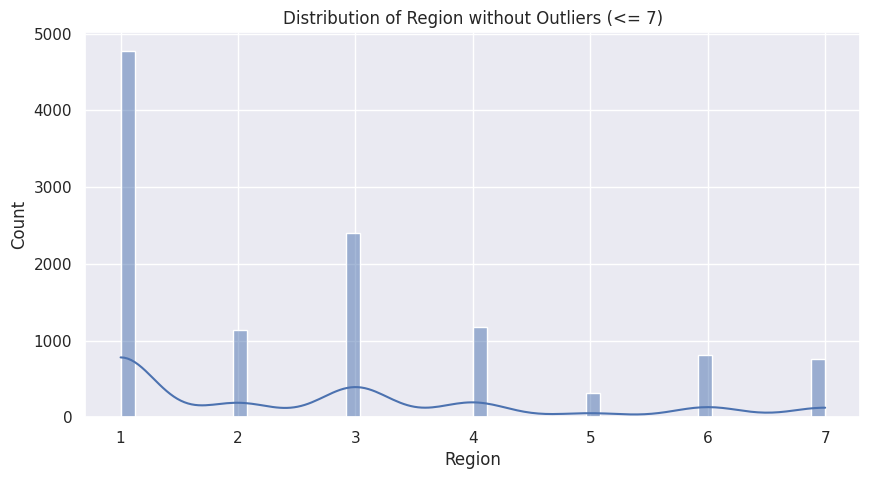

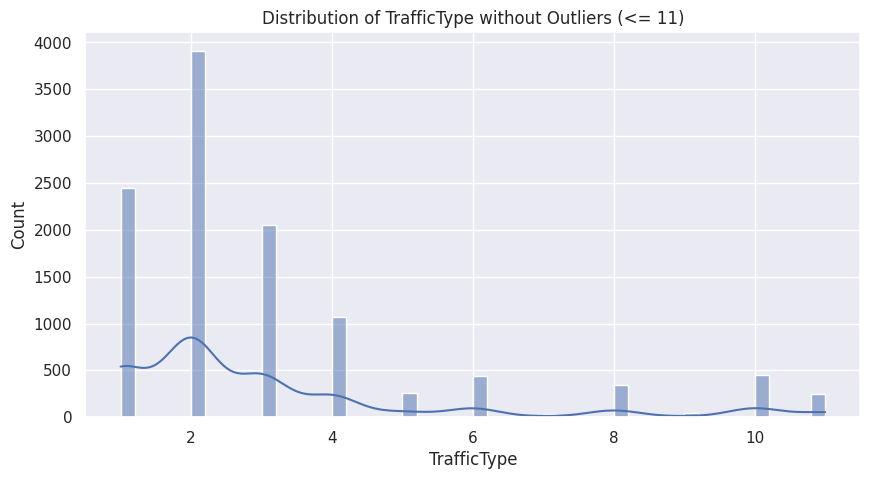

In [2381]:
# Identificarea atributelor numerice
numeric_features = df.select_dtypes(include=[np.number]).columns
for feature in numeric_features:
    # Calculați percentilele cu granularitate de 10%
    percentiles = np.percentile(df[feature], np.arange(0, 101, 10))
    
    # Alegem pragul pentru a elimina outlierii (de exemplu, 90th percentile)
    threshold = percentiles[9]
    
    # Filtrați datele pentru a elimina outlierii
    filtered_data = df[df[feature] <= threshold]
    
    # Realizați un grafic pentru distribuția valorilor fără outlieri
    plt.figure(figsize=(10, 5))
    sns.histplot(filtered_data[feature], bins=50, kde=True)
    
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(f'Distribution of {feature} without Outliers (<= {int(threshold)})')
    plt.show()

### 2.A Atribute Categorice

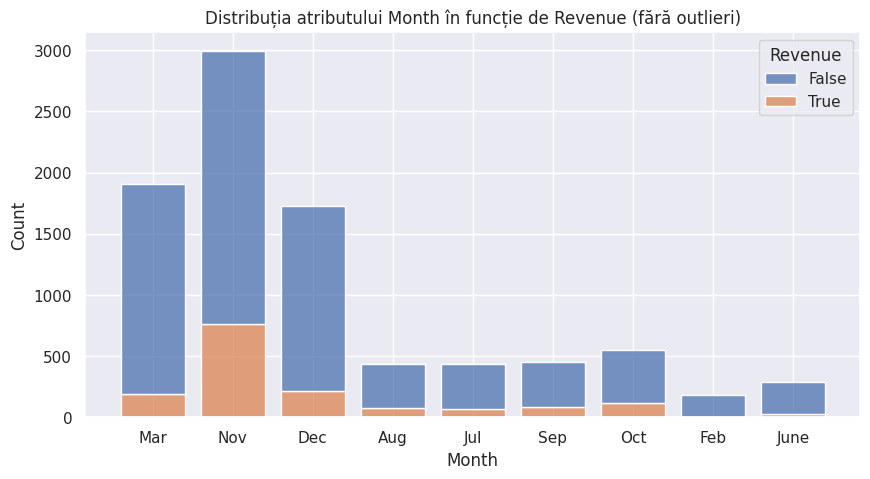

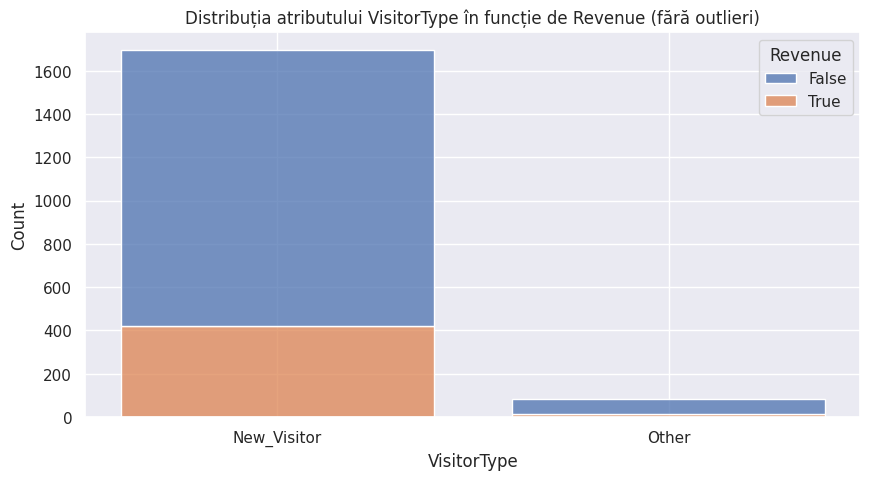

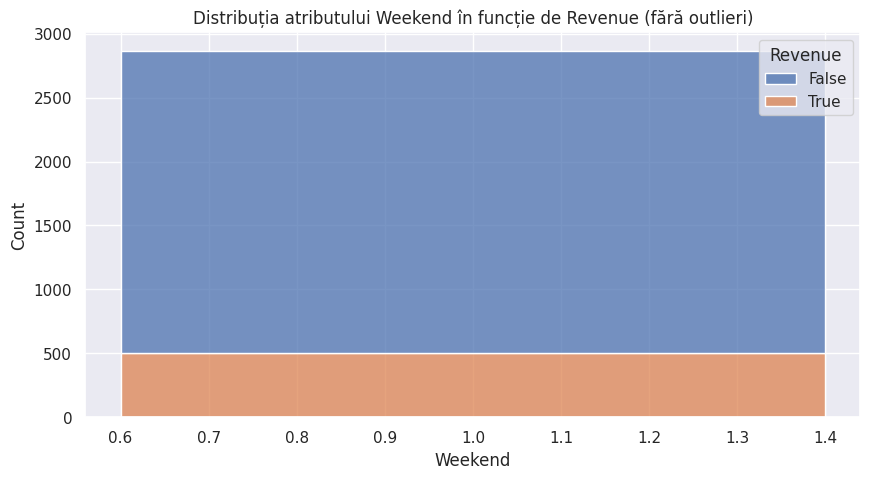

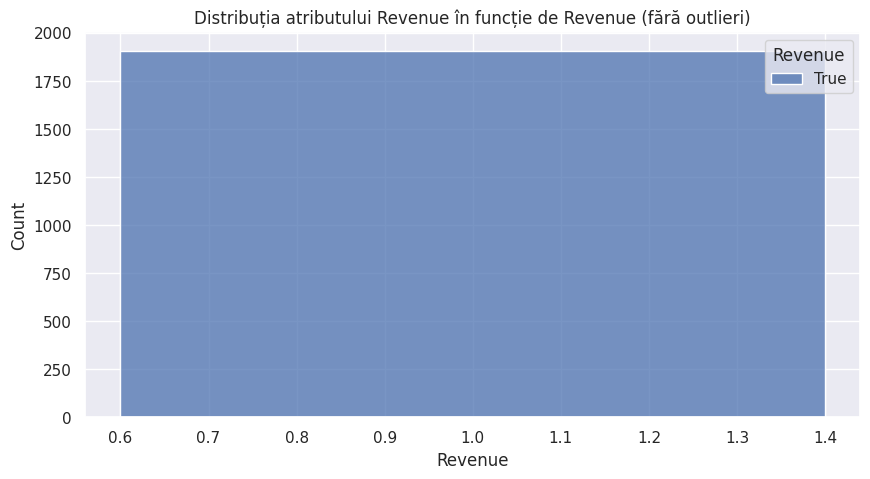

In [2382]:
# Identificarea atributelor categorice
categorical_attributes = df.select_dtypes(exclude=np.number).columns.tolist()

for attribute in categorical_attributes:
    # Calculăm frecvența pentru fiecare categorie
    category_counts = df[attribute].value_counts()

    # Alegem un prag pentru a elimina categoriile cu o frecvență mai mare decât percentilele specificate (de exemplu, 90th percentile)
    threshold = np.percentile(category_counts, 90)

    # Filtrăm datele pentru a păstra doar categoriile cu frecvență sub prag
    df_filtered = df[df[attribute].isin(category_counts[category_counts <= threshold].index)]

    # Realizăm un grafic pentru distribuția categoriilor după eliminarea outlierilor
    plt.figure(figsize=(10, 5))
    sns.histplot(x=attribute, data=df_filtered, hue='Revenue', multiple='stack', shrink=0.8)
    plt.title(f'Distribuția atributului {attribute} în funcție de Revenue (fără outlieri)')
    plt.show()


## 3. Analiza Gradului de Corelare

### 3.A Atribute Numerice cu Coeficientul de Point-Biserial

                  Attribute  Correlation        P-Value
0            Administrative     0.138917   3.519760e-54
1   Administrative_Duration     0.093587   2.146514e-25
2             Informational     0.095200   3.174034e-26
3    Informational_Duration     0.070345   5.282871e-15
4            ProductRelated     0.158538   3.241187e-70
5   ProductRelated_Duration     0.152373   6.115338e-65
6               BounceRates    -0.150673   1.594198e-63
7                 ExitRates    -0.207071  1.662654e-119
8                PageValues     0.492569   0.000000e+00
9                SpecialDay    -0.082305   5.498934e-20
10         OperatingSystems    -0.014668   1.033943e-01
11                  Browser     0.023984   7.736888e-03
12                   Region    -0.011595   1.979426e-01
13              TrafficType    -0.005113   5.702434e-01




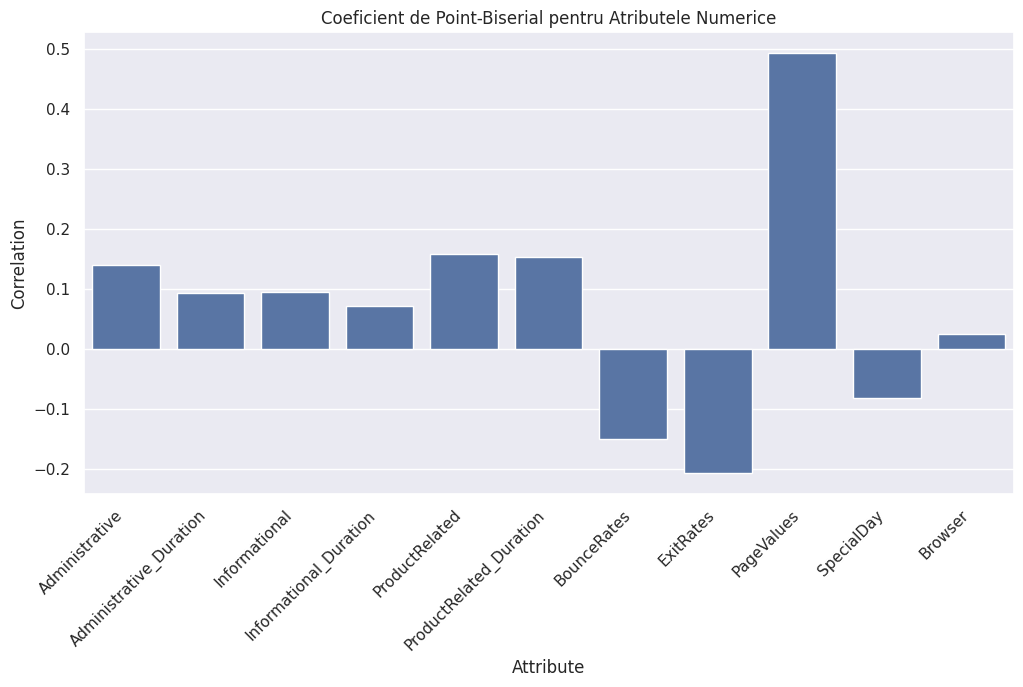

In [2362]:
correlation_results_numeric = []

for attribute in numeric_attributes:
    if attribute != 'Revenue':
        correlation, p_value = pointbiserialr(df[attribute], df['Revenue'])
        correlation_results_numeric.append({'Attribute': attribute, 'Correlation': correlation, 'P-Value': p_value})

# Tabelul cu rezultate
correlation_df_numeric = pd.DataFrame(correlation_results_numeric)
print(correlation_df_numeric)
print('\n')

# Vizualizare pentru atributele cu p-value <= 0.05
significant_numeric_attributes = correlation_df_numeric[correlation_df_numeric['P-Value'] <= 0.05]
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='Attribute', y='Correlation', data=significant_numeric_attributes)
plt.title('Coeficient de Point-Biserial pentru Atributele Numerice')

# Rotirea etichetelor pe axa X pentru a face vizualizarea mai lizibilă
X_fields = significant_numeric_attributes['Attribute'].tolist()
barplot.set_xticks(range(len(X_fields)))
barplot.set_xticklabels(X_fields, rotation=45, horizontalalignment='right')

plt.show()

### 3.B Atribute Categorice cu Testul Chi-squared

     Attribute   Chi-squared       P-Value
0        Month    384.934762  2.238786e-77
1  VisitorType    135.251923  4.269904e-30
2      Weekend     10.390978  1.266325e-03
3      Revenue  12322.355847  0.000000e+00




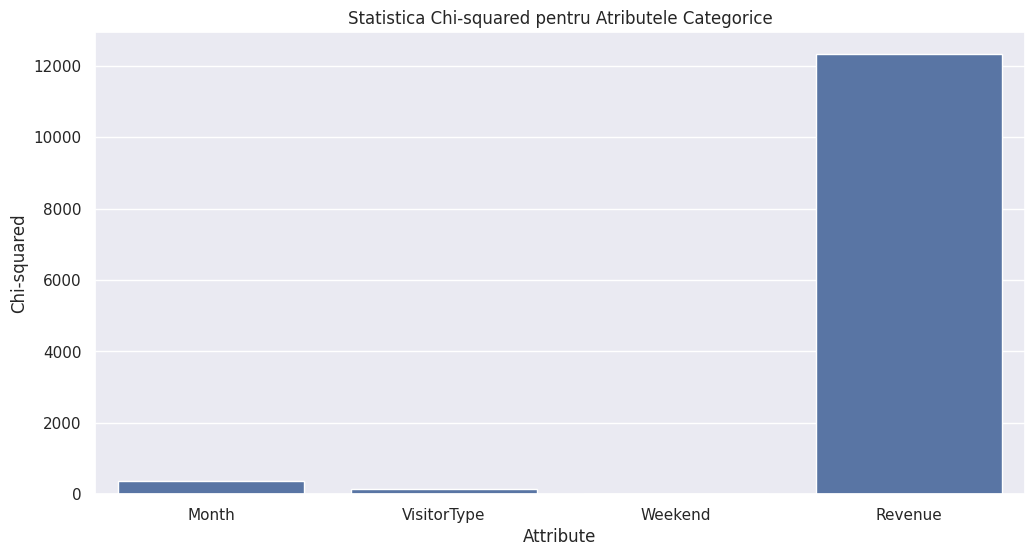

In [2363]:
correlation_results_categorical = []

for attribute in categorical_attributes:
    contingency_table = pd.crosstab(df[attribute], df['Revenue'])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    correlation_results_categorical.append({'Attribute': attribute, 'Chi-squared': chi2, 'P-Value': p_value})

# Tabelul cu rezultate
correlation_df_categorical = pd.DataFrame(correlation_results_categorical)
print(correlation_df_categorical)
print('\n')

# Vizualizare pentru atributele cu p-value <= 0.05
significant_categorical_attributes = correlation_df_categorical[correlation_df_categorical['P-Value'] <= 0.05]
plt.figure(figsize=(12, 6))
sns.barplot(x='Attribute', y='Chi-squared', data=significant_categorical_attributes)
plt.title('Statistica Chi-squared pentru Atributele Categorice')
plt.show()


# 3.2. Antrenarea și Evaluarea Algoritmilor de Predicție

#### Setting some variables needed for the comparison

In [2364]:
# Plot X axis step
STEP_PERCENT=1.25
# Number of times to run the function
num_iterations = 10

## 3.2.1. Regresie Logistică

### 1. Implementare manuală

#### Regresia Logistica

In [2365]:
clipped_value = 500

def split_dataset(X, T, train=.8):
    N = X.shape[0]
    N_train = int(round(N * train))
    N_test = N - N_train

    X_train, X_test = X[:N_train, :], X[N_train:, :]
    T_train, T_test = T[:N_train], T[N_train:]
    return X_train, T_train, X_test, T_test

def logistic(x):
    # Clip the input values to prevent overflow
    clipped_x = np.clip(x, -clipped_value, clipped_value)
    
    # Calculate the logistic function on the clipped values
    return 1 / (1 + np.exp(-clipped_x))

# Negative Log Likelihood - functia J(w)
def nll(Y, T):
    epsilon = 1e-15
    Y = np.clip(Y, epsilon, 1 - epsilon)
    return -np.mean(T * np.log(Y) + (1 - T) * np.log(1 - Y))

def accuracy(Y, T):
    predicted_labels = np.round(Y)
    correct_predictions = np.sum(predicted_labels == T)
    total_samples = len(T)
    return correct_predictions / total_samples

# Antrenati modelul logistic (ponderile W), executand epochs_no pasi din algoritmul de gradient descent
def train_logistic(X, T, lr=0.01, epochs_no=100):
    (N, D) = X.shape
    X_hat = np.concatenate([X, np.ones((N, 1))], axis=1)
    W = np.random.randn(D + 1)

    for epoch in range(epochs_no):
        Y = logistic(np.dot(X_hat, W))
        gradient = np.dot(X_hat.T, (Y - T))
        W -= lr * gradient

    return W

# Calculati predictia Y a modelului logistic antrenat (ponderile W invatate)
def predict_logistic(X, W):
    X_hat = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
    Y = logistic(np.dot(X_hat, W))
    return Y

def train_logistic_full(X, T, lr=0.01, learning_increase_percent=2.5, epochs_no=1000):
    (N, D) = X.shape
    X1 = np.concatenate([np.ones((N, 1)), X], axis=1)
    W = np.random.randn(D + 1)

    X_train, T_train, X_test, T_test = split_dataset(X1, T)
    
    train_acc, test_acc = [], []
    train_nll, test_nll = [], []
    W_trace = [W.copy()]

    for epoch in range(epochs_no):
        # Maresc learning rate-ul pt fiecare epoch
        lr = lr * (1 + learning_increase_percent / 100) 
        
        Y_train = logistic(X_train @ W)
        
        gradient = np.transpose(X_train) @ (Y_train-T_train)/N
        W -= lr * gradient

        logits = np.dot(X_test, W)
        Y_test = 1. / (1. + np.exp(-np.clip(logits, -clipped_value, clipped_value)))

        train_acc.append(accuracy(Y_train, T_train))
        test_acc.append(accuracy(Y_test, T_test))
        train_nll.append(nll(Y_train, T_train))
        test_nll.append(nll(Y_test, T_test))
        W_trace.append(W.copy())

    return W, train_acc, test_acc, train_nll, test_nll, W_trace

#### Preprocesarea datelor

In [2366]:
def preprocess_data(df):
    # Split set de date în caracteristici (X) și variabilă țintă (y)
    X = df.drop('Revenue', axis=1)
    y = df['Revenue'] # Revenue este boolean ( 0 / 1)
    
    # Conversia variabilelor categorice în formă numerică
    label_encoder = LabelEncoder()
    categorical_columns = ['Month', 'VisitorType', 'Weekend']
    for column in categorical_columns:
        X[column] = label_encoder.fit_transform(X[column])

    return X, y

#### Functie pentru plotting

In [2367]:
# Definim o functie ajutatoare pentru plotting
def plot_evolution(train_acc, test_acc, train_nll, test_nll, scaler, step_percent=2.5):
    # Step_percent = 5 <==> 100 / 5 == 20 X points on the plot
    epochs_no = len(train_acc)
    step = round(epochs_no * step_percent / 100)
    # If step is 0, we will set minimum default step for the plotting
    if step == 0:
        step = 1
    fig, (ax1, ax2) = plt.subplots(2, 1)

    # Plotting accuracy evolution
    ax1.plot(range(0, epochs_no, step), train_acc[::step], sns.xkcd_rgb["green"], label="Train Accuracy")
    ax1.plot(range(0, epochs_no, step), test_acc[::step], sns.xkcd_rgb["red"], label="Test Accuracy")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc='lower right', ncol=1)

    # Plotting negative log likelihood evolution
    ax2.plot(range(0, epochs_no, step), train_nll[::step], sns.xkcd_rgb["green"], label="Train NLL")
    ax2.plot(range(0, epochs_no, step), test_nll[::step], sns.xkcd_rgb["red"], label="Test NLL")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("NLL")
    ax2.legend(loc='upper right', ncol=1)

    # Adding title with scaler information
    plt.suptitle(f'Evolution with Scaler: {scaler}')
    plt.show()
    
    return (ax1, ax2)

In [2368]:
# Function to print metrics for a specific measure (e.g., accuracy, precision, recall, f1_score)
def print_metrics(metric_name, results_dict, num_iterations):
    for scaler_name, metric_list in results_dict.items():
        mean_metric = np.mean(metric_list)
        median_metric = np.median(metric_list)
        variance_metric = np.var(metric_list)
        min_metric = np.min(metric_list)
        max_metric = np.max(metric_list)

        print(f"\nMetrics for {metric_name} with {scaler_name} after {num_iterations} runs:")
        print(f"Mean {metric_name}: {mean_metric}")
        print(f"Median {metric_name}: {median_metric}")
        print(f"Variance {metric_name}: {variance_metric}")
        print(f"Min {metric_name}: {min_metric}")
        print(f"Max {metric_name}: {max_metric}")

#### Datele de fitting ale modelului

In [2369]:
EPOCHS_NO = 200
LR = 0.035
LEARNING_INCREASE_PERCENT = 1

### Scalers

In [2370]:
# Normalizarea datelor (Scalare)
scalers = {
        'MinMaxScaler': MinMaxScaler(),
        'StandardScaler': StandardScaler(),
        'RobustScaler': RobustScaler()
}

In [2371]:
def logistic_regression_manual(X, y, lr=0.01, learning_increase_percent=2.5, epochs_no=100, step_percent=100):
    # Modify the dataset to include only the features we consider relevant to our target
    selected_features = ['ProductRelated', 'ProductRelated_Duration', 
                         'BounceRates', 'ExitRates', 'PageValues',
                         'SpecialDay', 'Month', 'Region', 'VisitorType', 'Weekend']
    X_selected = X[selected_features]
    
    # Iterate over the scalers
    for scaler_name, scaler in scalers.items():
        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
        # Scalarea datelor de antrenare
        X_train_scaled = scaler.fit_transform(X_train)

        # Antrenarea modelului logistic
        W, train_acc, test_acc, train_nll, test_nll, W_trace = train_logistic_full(X_train_scaled, y_train, lr=lr, epochs_no=epochs_no)

        # Evaluarea modelului pe setul de testare
        X_test_scaled = scaler.transform(X_test)
        Y_test = predict_logistic(X_test_scaled, W)

        # Evaluare metrici pe setul de testare
        precision = precision_score(y_test, np.round(Y_test))
        recall = recall_score(y_test, np.round(Y_test))
        f1 = f1_score(y_test, np.round(Y_test))
        test_accuracy = accuracy(Y_test, y_test)

        # Afișare și salvare metrici
        print(f"Acuratete folosind {scaler_name}: {test_accuracy}")
        print(f"Precision folosind {scaler_name}: {precision}")
        print(f"Recall folosind {scaler_name}: {recall}")
        print(f"F1 Score folosind {scaler_name}: {f1}")
        
        # Save metric values in dictionaries
        if scaler_name not in precision_results:
            precision_results[scaler_name] = []
        precision_results[scaler_name].append(precision)
        if scaler_name not in recall_results:
            recall_results[scaler_name] = []
        recall_results[scaler_name].append(recall)
        if scaler_name not in f1_score_results:
            f1_score_results[scaler_name] = []
        f1_score_results[scaler_name].append(f1)
        if scaler_name not in accuracy_results:
            accuracy_results[scaler_name] = []
        accuracy_results[scaler_name].append(test_accuracy)

        # Vizualizare evolutie
        plot_evolution(train_acc, test_acc, train_nll, test_nll, scaler, step_percent)
        
        # Eliberare memorie
        del X_train, X_train_scaled, X_test_scaled, Y_test, W, train_acc, test_acc, train_nll, test_nll, W_trace

#### Rulam de 10 ori algoritmul pe sample-uri random ale datasetului initial

Training dataset size: 12330
Number of features: 17

RULAREA NUMARUL 1
Acuratete folosind MinMaxScaler: 0.6257096512570965
Precision folosind MinMaxScaler: 0.13272010512483573
Recall folosind MinMaxScaler: 0.2774725274725275
F1 Score folosind MinMaxScaler: 0.17955555555555552


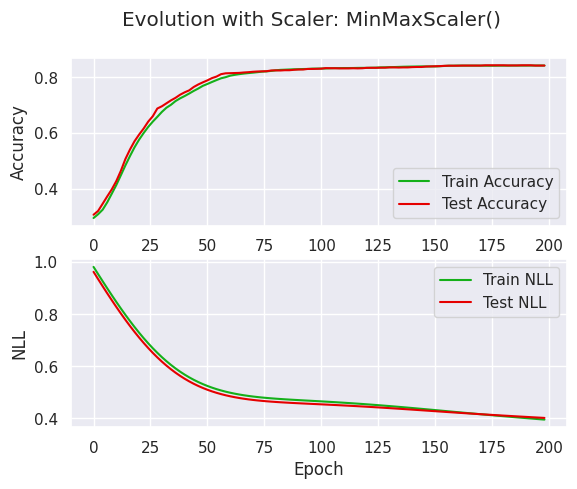

Acuratete folosind StandardScaler: 0.32765612327656124
Precision folosind StandardScaler: 0.05121107266435986
Recall folosind StandardScaler: 0.20498614958448755
F1 Score folosind StandardScaler: 0.08194905869324474


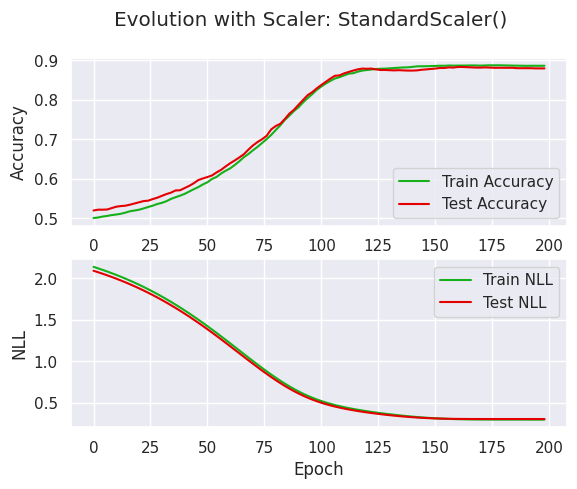

Acuratete folosind RobustScaler: 0.451338199513382
Precision folosind RobustScaler: 0.03418803418803419
Recall folosind RobustScaler: 0.0967741935483871
F1 Score folosind RobustScaler: 0.05052631578947368


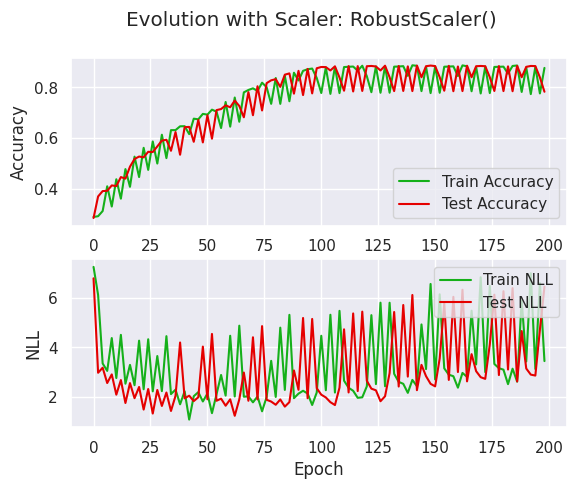


RULAREA NUMARUL 2
Acuratete folosind MinMaxScaler: 0.7461476074614761
Precision folosind MinMaxScaler: 0.14516129032258066
Recall folosind MinMaxScaler: 0.14917127071823205
F1 Score folosind MinMaxScaler: 0.14713896457765668


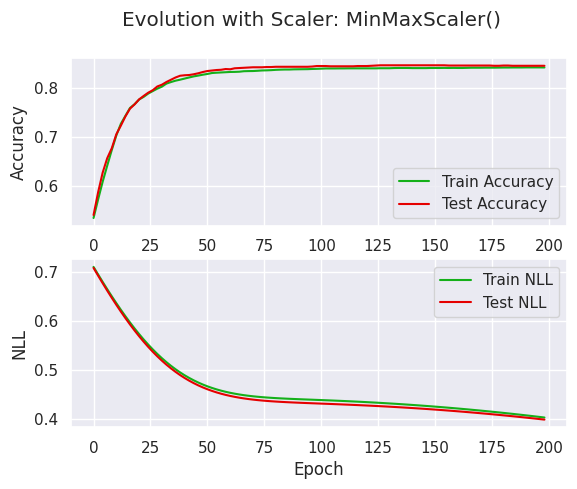

Acuratete folosind StandardScaler: 0.37550689375506896
Precision folosind StandardScaler: 0.10335195530726257
Recall folosind StandardScaler: 0.36633663366336633
F1 Score folosind StandardScaler: 0.16122004357298472


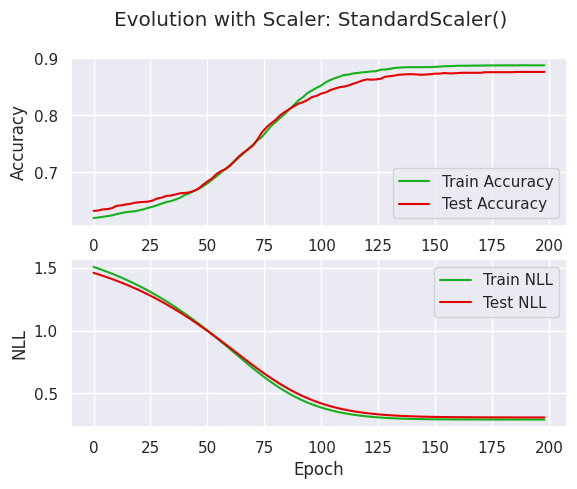

Acuratete folosind RobustScaler: 0.4764801297648013
Precision folosind RobustScaler: 0.025559105431309903
Recall folosind RobustScaler: 0.06
F1 Score folosind RobustScaler: 0.035847647498132934


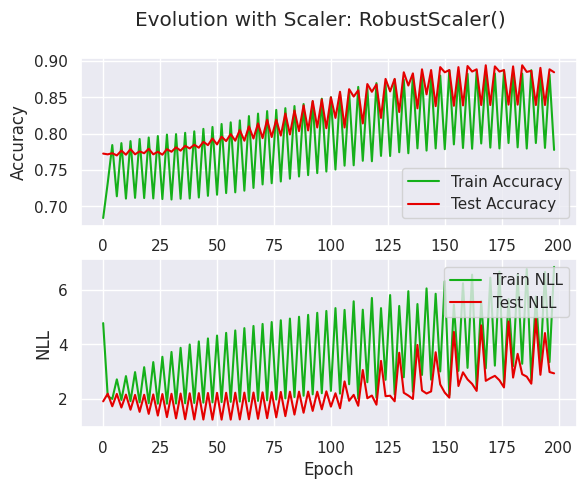


RULAREA NUMARUL 3
Acuratete folosind MinMaxScaler: 0.8045417680454177
Precision folosind MinMaxScaler: 0.1437908496732026
Recall folosind MinMaxScaler: 0.058981233243967826
F1 Score folosind MinMaxScaler: 0.08365019011406843


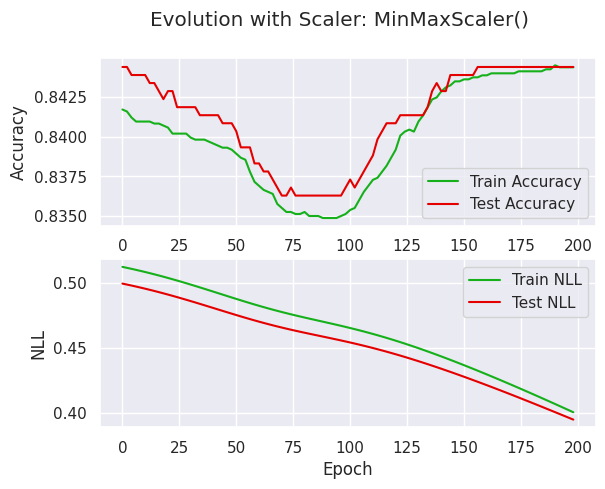

Acuratete folosind StandardScaler: 0.4326845093268451
Precision folosind StandardScaler: 0.1291248206599713
Recall folosind StandardScaler: 0.4931506849315068
F1 Score folosind StandardScaler: 0.2046617396247868


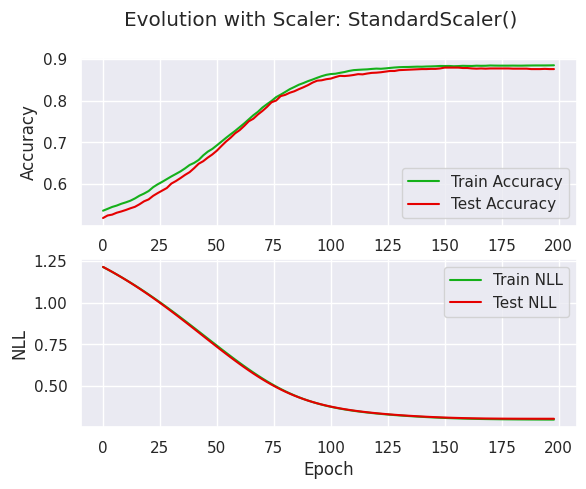

Acuratete folosind RobustScaler: 0.6772100567721006
Precision folosind RobustScaler: 0.01818181818181818
Recall folosind RobustScaler: 0.021505376344086023
F1 Score folosind RobustScaler: 0.019704433497536946


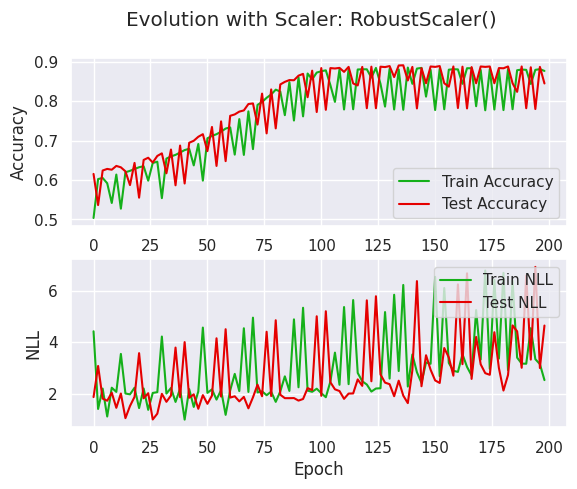


RULAREA NUMARUL 4
Acuratete folosind MinMaxScaler: 0.8017031630170316
Precision folosind MinMaxScaler: 0.055900621118012424
Recall folosind MinMaxScaler: 0.02601156069364162
F1 Score folosind MinMaxScaler: 0.03550295857988166


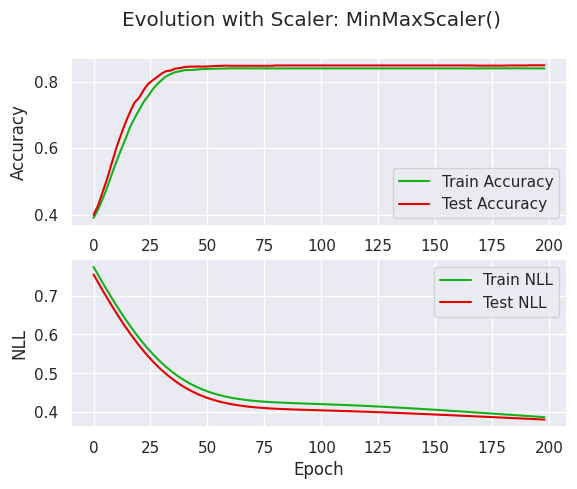

Acuratete folosind StandardScaler: 0.3499594484995945
Precision folosind StandardScaler: 0.08602150537634409
Recall folosind StandardScaler: 0.3450134770889488
F1 Score folosind StandardScaler: 0.13770844540075308


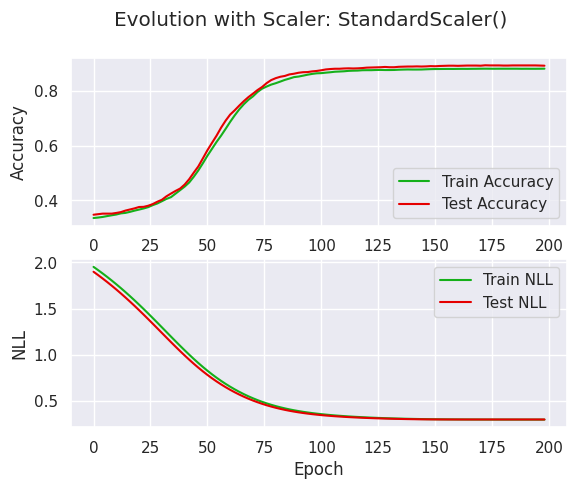

Acuratete folosind RobustScaler: 0.467558799675588
Precision folosind RobustScaler: 0.029233870967741934
Recall folosind RobustScaler: 0.07651715039577836
F1 Score folosind RobustScaler: 0.04230488694383661


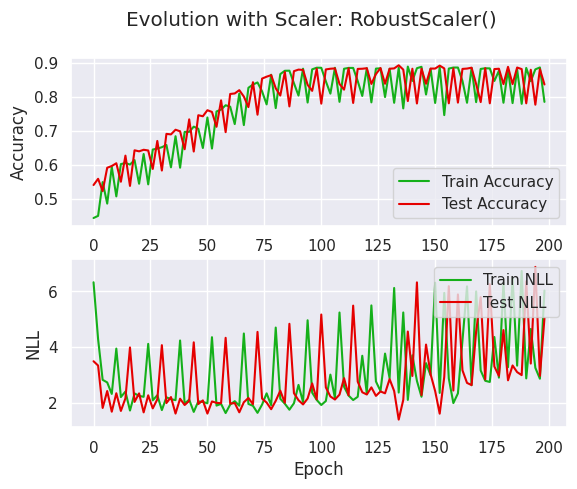


RULAREA NUMARUL 5
Acuratete folosind MinMaxScaler: 0.27899432278994324
Precision folosind MinMaxScaler: 0.13406364110589464
Recall folosind MinMaxScaler: 0.6853333333333333
F1 Score folosind MinMaxScaler: 0.2242582897033159


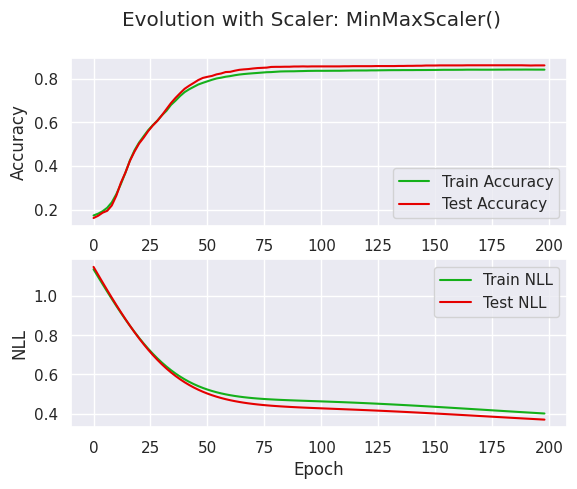

Acuratete folosind StandardScaler: 0.33779399837794
Precision folosind StandardScaler: 0.08899456521739131
Recall folosind StandardScaler: 0.30969267139479906
F1 Score folosind StandardScaler: 0.1382585751978892


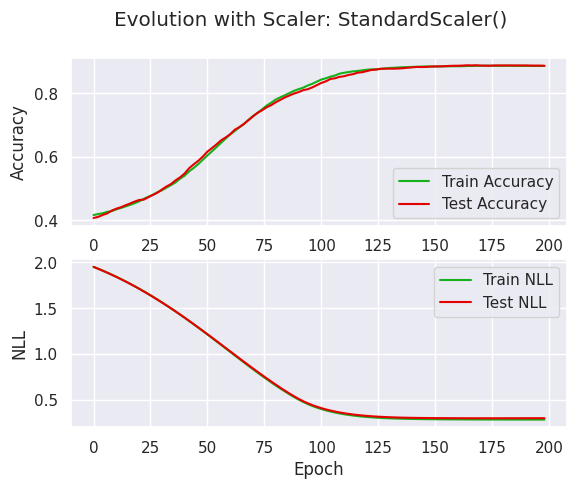

Acuratete folosind RobustScaler: 0.47039740470397406
Precision folosind RobustScaler: 0.04178814382896016
Recall folosind RobustScaler: 0.1184573002754821
F1 Score folosind RobustScaler: 0.06178160919540231


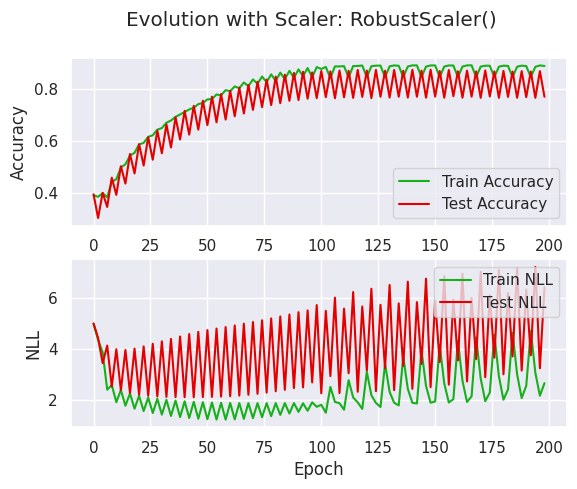


RULAREA NUMARUL 6
Acuratete folosind MinMaxScaler: 0.7777777777777778
Precision folosind MinMaxScaler: 0.0761904761904762
Recall folosind MinMaxScaler: 0.043243243243243246
F1 Score folosind MinMaxScaler: 0.05517241379310345


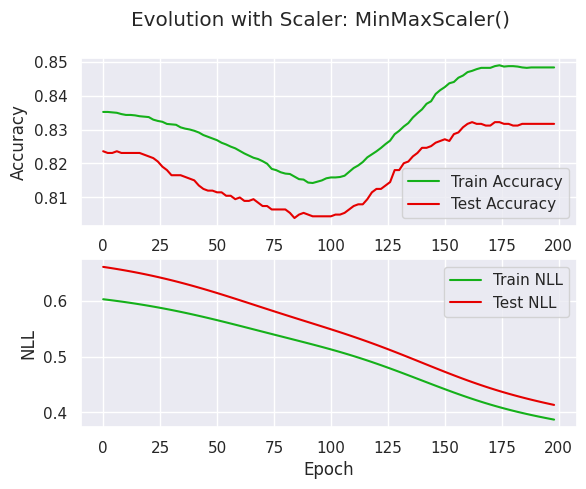

Acuratete folosind StandardScaler: 0.3337388483373885
Precision folosind StandardScaler: 0.06092436974789916
Recall folosind StandardScaler: 0.2236503856041131
F1 Score folosind StandardScaler: 0.0957622454595487


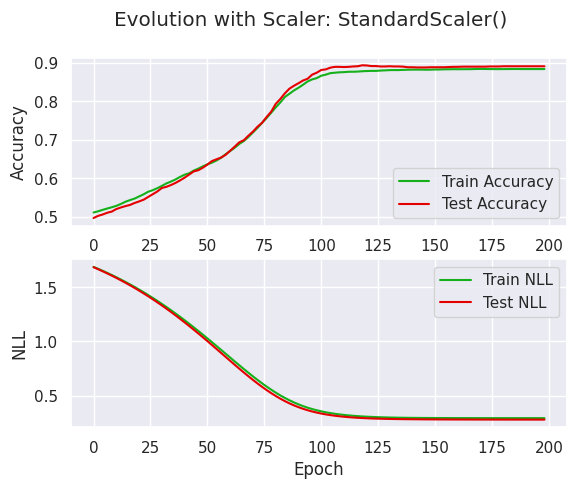

Acuratete folosind RobustScaler: 0.46634225466342255
Precision folosind RobustScaler: 0.05303030303030303
Recall folosind RobustScaler: 0.15053763440860216
F1 Score folosind RobustScaler: 0.0784313725490196


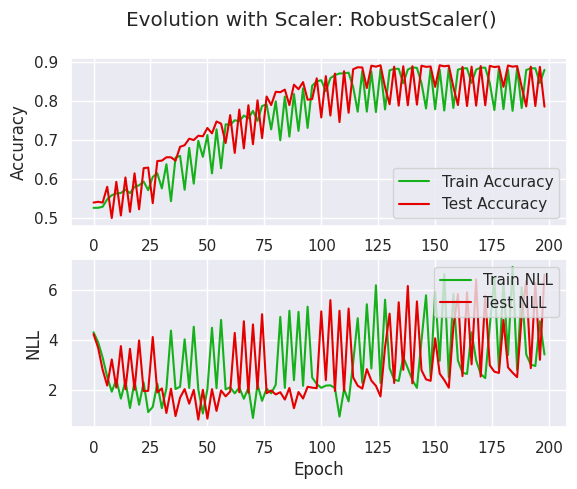


RULAREA NUMARUL 7
Acuratete folosind MinMaxScaler: 0.7660178426601785
Precision folosind MinMaxScaler: 0.18506493506493507
Recall folosind MinMaxScaler: 0.14882506527415143
F1 Score folosind MinMaxScaler: 0.1649782923299566


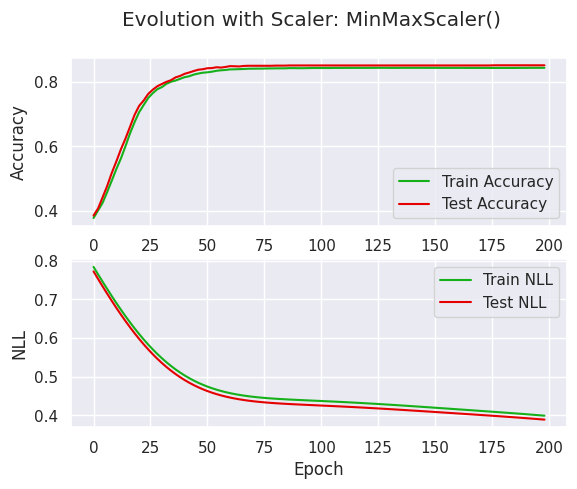

Acuratete folosind StandardScaler: 0.3353609083536091
Precision folosind StandardScaler: 0.06100068540095956
Recall folosind StandardScaler: 0.24860335195530725
F1 Score folosind StandardScaler: 0.09796367638965328


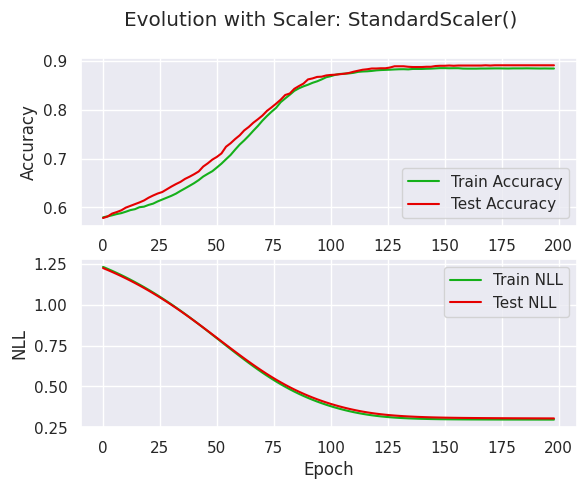

Acuratete folosind RobustScaler: 0.48094079480940793
Precision folosind RobustScaler: 0.06315789473684211
Recall folosind RobustScaler: 0.17983651226158037
F1 Score folosind RobustScaler: 0.09348441926345609


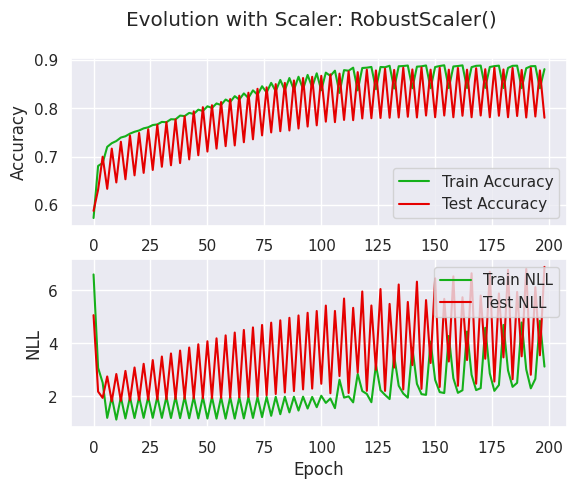


RULAREA NUMARUL 8
Acuratete folosind MinMaxScaler: 0.7230332522303325
Precision folosind MinMaxScaler: 0.07584269662921349
Recall folosind MinMaxScaler: 0.07086614173228346
F1 Score folosind MinMaxScaler: 0.07327001356852103


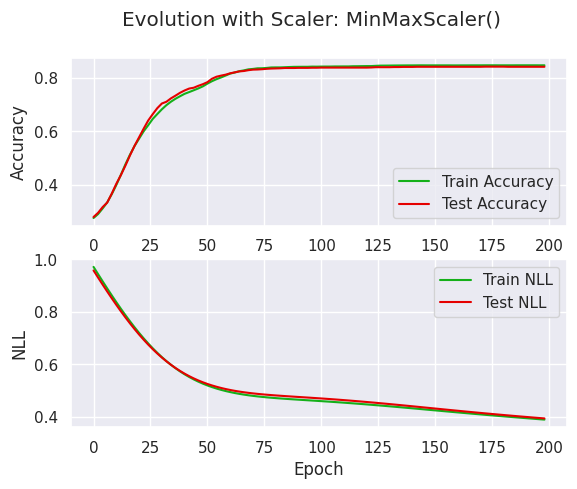

Acuratete folosind StandardScaler: 0.33171127331711275
Precision folosind StandardScaler: 0.060564349621472814
Recall folosind StandardScaler: 0.2371967654986523
F1 Score folosind StandardScaler: 0.09649122807017543


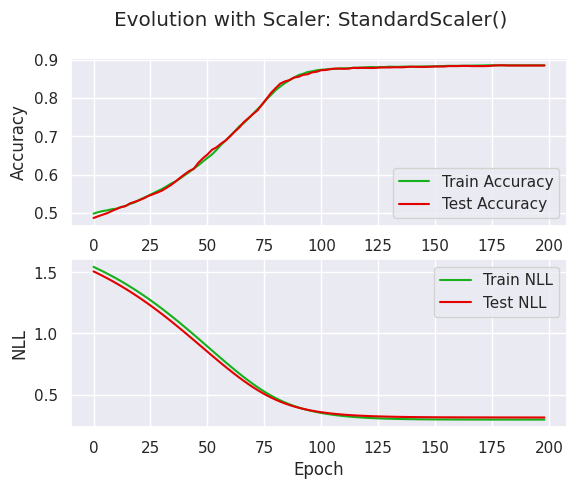

Acuratete folosind RobustScaler: 0.4854014598540146
Precision folosind RobustScaler: 0.03684210526315789
Recall folosind RobustScaler: 0.08997429305912596
F1 Score folosind RobustScaler: 0.05227781926811052


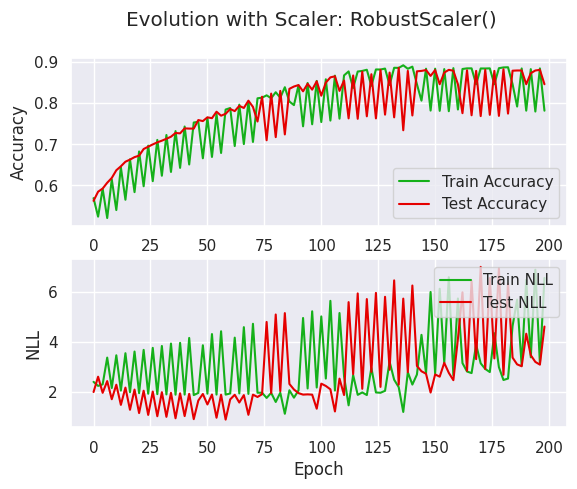


RULAREA NUMARUL 9
Acuratete folosind MinMaxScaler: 0.6236820762368208
Precision folosind MinMaxScaler: 0.12338593974175036
Recall folosind MinMaxScaler: 0.21339950372208435
F1 Score folosind MinMaxScaler: 0.15636363636363637


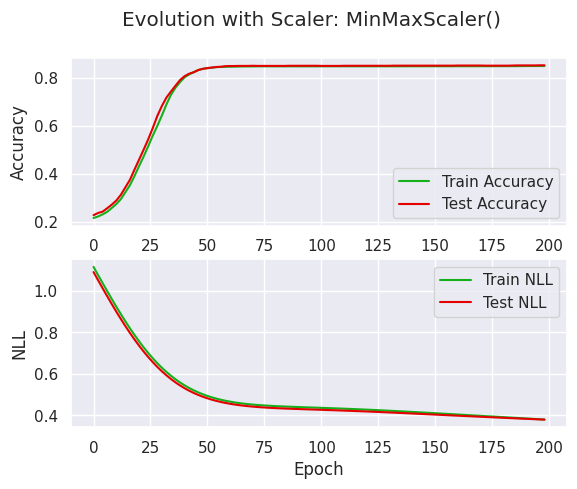

Acuratete folosind StandardScaler: 0.38077858880778587
Precision folosind StandardScaler: 0.08479327259985985
Recall folosind StandardScaler: 0.3538011695906433
F1 Score folosind StandardScaler: 0.13680045223289994


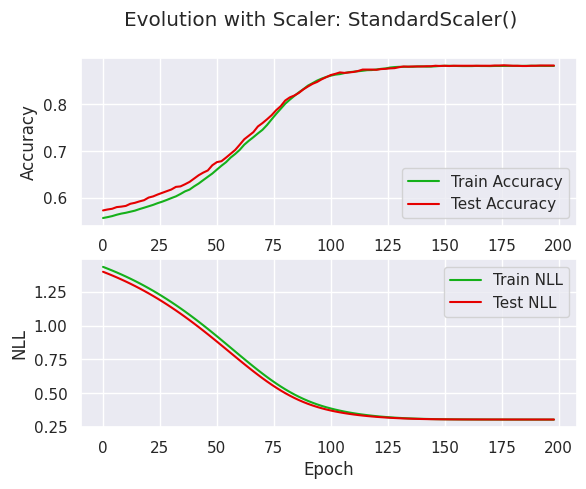

Acuratete folosind RobustScaler: 0.47850770478507704
Precision folosind RobustScaler: 0.028717948717948718
Recall folosind RobustScaler: 0.07629427792915532
F1 Score folosind RobustScaler: 0.041728763040238454


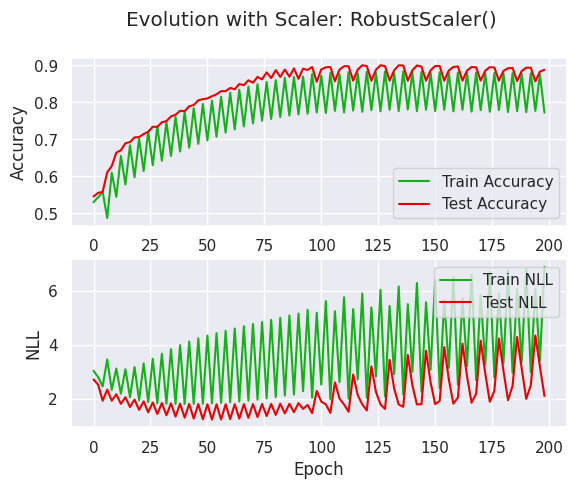


RULAREA NUMARUL 10
Acuratete folosind MinMaxScaler: 0.813463098134631
Precision folosind MinMaxScaler: 0.11811023622047244
Recall folosind MinMaxScaler: 0.04132231404958678
F1 Score folosind MinMaxScaler: 0.06122448979591837


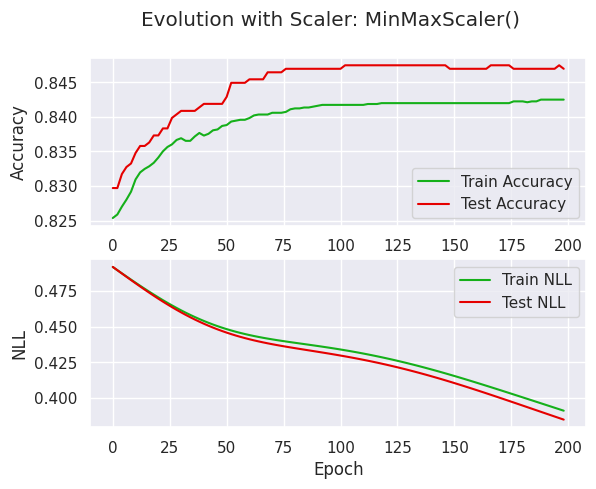

Acuratete folosind StandardScaler: 0.41565287915652877
Precision folosind StandardScaler: 0.11627906976744186
Recall folosind StandardScaler: 0.4155844155844156
F1 Score folosind StandardScaler: 0.18171493469619535


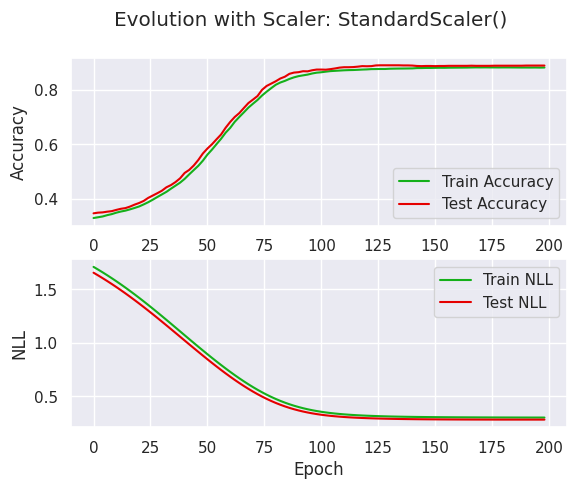

Acuratete folosind RobustScaler: 0.4651257096512571
Precision folosind RobustScaler: 0.0392156862745098
Recall folosind RobustScaler: 0.10554089709762533
F1 Score folosind RobustScaler: 0.057183702644746245


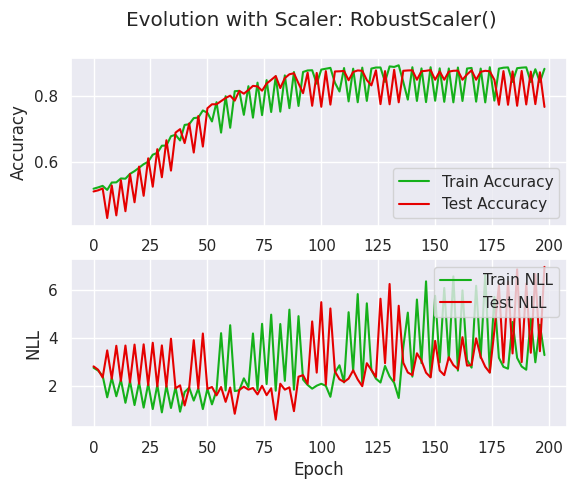

In [2372]:
# Print information about the training dataset
(N, D) = df.shape
print(f"Training dataset size: {N}")
print(f"Number of features: {D - 1}")

# Create dictionaries to store metric values
precision_results = {}
recall_results = {}
f1_score_results = {}
accuracy_results = {}

for iteration in range(num_iterations):
    # Amestecarea (randomizarea) rândurilor
    df = df.sample(frac=1).reset_index(drop=True)
    # Preprocesarea datelor
    X, y = preprocess_data(df.copy())

    print(f"\nRULAREA NUMARUL {iteration + 1}")
    # Apelul funcției cu datele specifice
    logistic_regression_manual(X,y,lr=LR,learning_increase_percent=LEARNING_INCREASE_PERCENT,epochs_no=EPOCHS_NO,step_percent=STEP_PERCENT)
    del X, y

#### Conclusion for the manual logistic regression

In [2373]:
print("\nFINAL STATISTICS")
# Print accuracy metrics
print("\nACCURACY")
print_metrics("Accuracy", accuracy_results, num_iterations)
# Print precision metrics
print("\nPRECISION")
print_metrics("Precision", precision_results, num_iterations)
# Print recall metrics
print("\nRECALL")
print_metrics("Recall", recall_results, num_iterations)
# Print F1 score metrics
print("\nF1")
print_metrics("F1 Score", f1_score_results, num_iterations)

del precision_results, recall_results, f1_score_results, accuracy_results


FINAL STATISTICS

ACCURACY

Metrics for Accuracy with MinMaxScaler after 10 runs:
Mean Accuracy: 0.6961070559610706
Median Accuracy: 0.7560827250608273
Variance Accuracy: 0.02356519714343786
Min Accuracy: 0.27899432278994324
Max Accuracy: 0.813463098134631

Metrics for Accuracy with StandardScaler after 10 runs:
Mean Accuracy: 0.3620843471208435
Median Accuracy: 0.34387672343876724
Variance Accuracy: 0.0012746079857185043
Min Accuracy: 0.32765612327656124
Max Accuracy: 0.4326845093268451

Metrics for Accuracy with RobustScaler after 10 runs:
Mean Accuracy: 0.4919302514193026
Median Accuracy: 0.4734387672343877
Variance Accuracy: 0.00389894454278101
Min Accuracy: 0.451338199513382
Max Accuracy: 0.6772100567721006

PRECISION

Metrics for Precision with MinMaxScaler after 10 runs:
Mean Precision: 0.11902307911913737
Median Precision: 0.12805302243329303
Variance Precision: 0.0013775492150872642
Min Precision: 0.055900621118012424
Max Precision: 0.18506493506493507

Metrics for Precision 

### 2. Implementare folosind scikit-learn

In [2374]:
def logistic_regression_scikit_learn(X, y, step_percent=100):
    # Iterate over the scalers
    for scaler_name, scaler in scalers.items():
        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
        # Scalarea datelor de antrenare
        X_train_scaled = scaler.fit_transform(X_train)
    
        # Create and train the logistic regression model
        model = LogisticRegression(random_state=None, max_iter=5000)
        model.fit(X_train_scaled, y_train)

        # Make predictions on the test set
        X_test_scaled = scaler.transform(X_test)
        y_pred = model.predict(X_test_scaled)
        
        # Evaluate the model
        test_accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Afișare și salvare metrici
        print(f"Acuratete folosind {scaler_name}: {test_accuracy}")
        print(f"Precision folosind {scaler_name}: {precision}")
        print(f"Recall folosind {scaler_name}: {recall}")
        print(f"F1 Score folosind {scaler_name}: {f1}")
        
        # Save metric values in dictionaries
        if scaler_name not in precision_results:
            precision_results[scaler_name] = []
        precision_results[scaler_name].append(precision)
        if scaler_name not in recall_results:
            recall_results[scaler_name] = []
        recall_results[scaler_name].append(recall)
        if scaler_name not in f1_score_results:
            f1_score_results[scaler_name] = []
        f1_score_results[scaler_name].append(f1)
        if scaler_name not in accuracy_results:
            accuracy_results[scaler_name] = []
        accuracy_results[scaler_name].append(test_accuracy)

        # Clean up variables
        del model

    # Clean up remaining variables
    del X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled

#### Rulam de 10 ori algoritmul pe sample-uri random ale datasetului initial

In [2375]:
# Print information about the training dataset
(N, D) = df.shape
print(f"Training dataset size: {N}")
print(f"Number of features: {D - 1}")

# Create dictionaries to store metric values
precision_results = {}
recall_results = {}
f1_score_results = {}
accuracy_results = {}

for iteration in range(num_iterations):
    # Amestecarea (randomizarea) rândurilor
    df = df.sample(frac=1).reset_index(drop=True)
    X, y = preprocess_data(df.copy())

    print(f"\nRUN NUMBER {iteration + 1}")
    # Apelul funcției cu datele specifice
    logistic_regression_scikit_learn(X, y, step_percent=STEP_PERCENT)
    del X, y

Training dataset size: 12330
Number of features: 17

RUN NUMBER 1
Acuratete folosind MinMaxScaler: 0.8669910786699108
Precision folosind MinMaxScaler: 0.7681159420289855
Recall folosind MinMaxScaler: 0.263681592039801
F1 Score folosind MinMaxScaler: 0.3925925925925926
Acuratete folosind StandardScaler: 0.8852392538523925
Precision folosind StandardScaler: 0.7637362637362637
Recall folosind StandardScaler: 0.36675461741424803
F1 Score folosind StandardScaler: 0.4955436720142603
Acuratete folosind RobustScaler: 0.8844282238442822
Precision folosind RobustScaler: 0.7722222222222223
Recall folosind RobustScaler: 0.3629242819843342
F1 Score folosind RobustScaler: 0.4937833037300178

RUN NUMBER 2
Acuratete folosind MinMaxScaler: 0.8824006488240065
Precision folosind MinMaxScaler: 0.7720588235294118
Recall folosind MinMaxScaler: 0.28846153846153844
F1 Score folosind MinMaxScaler: 0.42
Acuratete folosind StandardScaler: 0.8706407137064072
Precision folosind StandardScaler: 0.7417582417582418
R

#### Conclusion for the scikit-learn logistic regression

In [2376]:
print("\nFINAL STATISTICS")
# Print accuracy metrics
print("\nACCURACY")
print_metrics("Accuracy", accuracy_results, num_iterations)
# Print precision metrics
print("\nPRECISION")
print_metrics("Precision", precision_results, num_iterations)
# Print recall metrics
print("\nRECALL")
print_metrics("Recall", recall_results, num_iterations)
# Print F1 score metrics
print("\nF1")
print_metrics("F1 Score", f1_score_results, num_iterations)

# Clean up remaining variables
del precision_results, recall_results, f1_score_results, accuracy_results


FINAL STATISTICS

ACCURACY

Metrics for Accuracy with MinMaxScaler after 10 runs:
Mean Accuracy: 0.8731954582319545
Median Accuracy: 0.8738848337388483
Variance Accuracy: 5.8510256931412175e-05
Min Accuracy: 0.862124898621249
Max Accuracy: 0.8828061638280617

Metrics for Accuracy with StandardScaler after 10 runs:
Mean Accuracy: 0.8840632603406327
Median Accuracy: 0.8848337388483374
Variance Accuracy: 4.5729792164516176e-05
Min Accuracy: 0.8706407137064072
Max Accuracy: 0.8957826439578265

Metrics for Accuracy with RobustScaler after 10 runs:
Mean Accuracy: 0.881021897810219
Median Accuracy: 0.8807785888077859
Variance Accuracy: 1.4214402656337084e-05
Min Accuracy: 0.875506893755069
Max Accuracy: 0.8868613138686131

PRECISION

Metrics for Precision with MinMaxScaler after 10 runs:
Mean Precision: 0.7638286817843
Median Precision: 0.7695541542205996
Variance Precision: 0.0012393291036255929
Min Precision: 0.7019867549668874
Max Precision: 0.816

Metrics for Precision with StandardScale

## 3.2.2. Arbore de Decizie

### 1. Implementare folosind scikit-learn

### 2. Implementare manuală